In [876]:
import numpy as np
import scipy
import random
import pandas as pd
import pickle
import seaborn.objects as so
import hashlib

import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats   

In [947]:
import glob
with open("Metrics_Folder/Metrics_18.pickle", 'rb') as handle:
    metrics = pickle.load(handle)

In [975]:
with open(f'Metrics_Folder/Metrics_{18}.pickle', 'wb') as handle:
    pickle.dump(metrics[:18], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [976]:
df_runs = pd.DataFrame(metrics).drop(["expert metrics", "verma", "hemmer"], axis=1)
df_runs

,labeler_ids,init_size,labels_per_round,rounds,labeled,cost,overlap,setting,mod,expert_predict,sample_equal
0,"[4323195249, 4295232296]",0,4,8,32,"(0, 0)",5,PERFECT,perfect,target,False
1,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,False
2,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,True
3,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,False
4,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,True
5,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,False
6,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,True
7,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,False
8,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,True
9,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,False


In [828]:
def get_values(run, method, metric_name, step):
    met = {}     
    for seed, el1 in metrics[run][method].items():
        for fold, el2 in el1.items():
            if method == "hemmer" and metric_name == "Classifier Coverage":
                n_images = getCountOfCoverage(metrics[run]["verma"][seed][fold][step][0]["coverage"])
                met[f"Seed_{seed}_Fold_{fold}"] = n_images * pd.Series([el3[metric_name] for key3, el3 in el2[step].items()])
            else:
                met[f"Seed_{seed}_Fold_{fold}"] = pd.Series([el3[metric_name] for key3, el3 in el2[step].items()])

    return pd.DataFrame(met)

def plot_metrics(met): 
    df = met.reset_index().melt('index', var_name='cols',  value_name='vals')
    sns.lineplot(df, x="index", y="vals", hue='cols',)

def check_all_ttest(df, p=0.05, equal_var=False):
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            res = get_ttest(df.iloc[:,[i]], df.iloc[:,[j]], equal_var=equal_var)
            if res.pvalue <= p:
                print(res)
                print(f"i: {df.columns[i]}, j: {df.columns[j]}")

def get_ttest(value1, value2, equal_var=True):
    res = ttest_ind(value1, value2, equal_var=equal_var)
    #print(res)
    return res


def create_runs_plot(metrics, method, metrics_name, step):
    values = []
    for i in range(len(metrics)):
        values.append(get_values(i, method, metrics_name, step))

    dic = []
    for value in values:
        dic.append(value.max())

    df = pd.DataFrame(dic)
    df = df.T.reset_index(drop=True)

    sns.boxplot(df)

    check_all_ttest(df, 0.05, True)

    df_runs.head(10)

def getCountOfCoverage(text):
    marker = None
    for j in range(len(text)):
        if text[-j] == "f":
            marker = j -1
    return int(text[-marker:])



In [813]:
def create_dataframe_one_metric(metric, run, method, seed, fold, step):
    if method == "verma":
        return create_dataframe_verma(metric, run, seed, fold, step)

def create_dataframe_verma(metric, run, seed, fold, step):
    df = pd.DataFrame(metrics[run]["verma"][seed][fold][step]).drop(["acc_experts", "cov_experts"], axis=0).T
    df["coverage"] = df["coverage"].apply(lambda x: getCountOfCoverage(x))
    df.rename(columns={'coverage':'n_images'}, inplace=True)
    return df

In [892]:
dict_run = {}
for run in range(len(metrics)):
    dict_seed = {}
    for seed, val1 in metrics[run]["verma"].items():
        dict_fold = {}
        for fold, element in metrics[run]["verma"][seed].items():
            dict_fold[f"Fold_{fold}"] = create_dataframe_one_metric(metrics, run, "verma", seed, fold, "val")
        df_seed = pd.concat(dict_fold)
        dict_seed[f"Seed_{seed}"] = df_seed
    df_run = pd.concat(dict_seed)
    dict_run[f"Run_{run}"] = df_run
df_test = pd.concat(dict_run)
df_test

n_images system_accuracy expert_accuracy  \
Run_0  Seed_1 Fold_0 0        168       79.761905       89.999775   
                     1        168       78.571429       93.102806   
                     2        168       78.571429       91.665903   
                     3        168       79.166667        92.85648   
                     4        168       83.928571       86.206302   
...                           ...             ...             ...   
Run_15 Seed_3 Fold_3 23       168        84.52381       90.475903   
                     24       168       82.738095       89.062222   
                     25       168       82.738095       90.163639   
                     26       168       82.142857       88.333039   
                     27       168       82.738095       87.878522   

                        classifier_accuracy alone_classifier validation_loss  \
Run_0  Seed_1 Fold_0 0            70.454465        69.047619         3.94559   
                     1            75.539514        75.595238        4.313956   
                     2            76.388836        76.190476        5.260923   
                     3            76.428517             75.0        6.615823   
                     4            83.453177        75.595238        6.591594   
...                                     ...              ...             ...   
Run_15 Seed_3 Fold_3 23           80.952304        79.166667        7.427717   
                     24           78.846078        80.952381        6.789392   
                     25             78.5046        81.547619        7.069191   
                     26           78.703631        80.357143        8.014874   
                     27           79.411687        79.761905        7.923684   

                        n_experts   expert_0   expert_1 expert_0_coverage  \
Run_0  Seed_1 Fold_0 0          2  91.488972  87.878255                47   
                     1          2  93.102806        0.0                29   
                     2          2  91.303554  99.980004                23   
                     3          2  95.453678  83.330556                22   
                     4          2  95.237188  62.498438                21   
...                           ...        ...        ...               ...   
Run_15 Seed_3 Fold_3 23         2  94.871308  83.332639                39   
                     24         2  92.856701  81.817438                42   
                     25         2  95.121487    79.9992                41   
                     26         2  94.736343  77.272025                38   
                     27         2  92.682475   79.99936                41   

                        expert_1_coverage cov_classifier  
Run_0  Seed_1 Fold_0 0                 33             88  
                     1                  0            139  
                     2                  1            144  
                     3                  6            140  
                     4                  8            139  
...                                   ...            ...  
Run_15 Seed_3 Fold_3 23                24            105  
                     24                22            104  
                     25                20            107  
                     26                22            108  
                     27                25            102  

[5107 rows x 12 columns]

In [913]:
pd.DataFrame(df_test["system_accuracy"]).groupby(level=1)

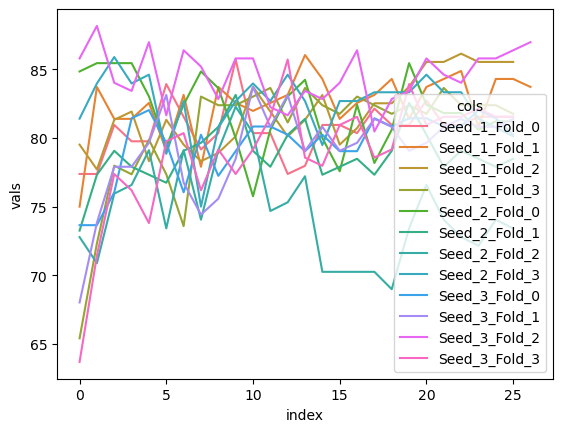

In [709]:
values = []
for i in range(len(metrics)):
    values.append(get_values(i, "verma", "system_accuracy", "val"))
plot_metrics(values[6])

Ttest_indResult(statistic=array([10.36616467]), pvalue=array([1.45920564e-07]))
i: 0, j: 3
Ttest_indResult(statistic=array([5.91268131]), pvalue=array([6.93482165e-05]))
i: 0, j: 4
Ttest_indResult(statistic=array([7.21857563]), pvalue=array([3.21524337e-06]))
i: 0, j: 13
Ttest_indResult(statistic=array([4.55137671]), pvalue=array([0.00059541]))
i: 0, j: 14
Ttest_indResult(statistic=array([4.70799064]), pvalue=array([0.00043773]))
i: 0, j: 15
Ttest_indResult(statistic=array([2.36360804]), pvalue=array([0.03295632]))
i: 0, j: 16
Ttest_indResult(statistic=array([8.54369269]), pvalue=array([4.93902839e-07]))
i: 0, j: 17
Ttest_indResult(statistic=array([5.98174247]), pvalue=array([5.10876695e-05]))
i: 0, j: 18
Ttest_indResult(statistic=array([-1.94103378]), pvalue=array([0.06585219]))
i: 3, j: 4
Ttest_indResult(statistic=array([-4.6605717]), pvalue=array([0.00016904]))
i: 3, j: 13
Ttest_indResult(statistic=array([-3.99510275]), pvalue=array([0.00061299]))
i: 3, j: 14
Ttest_indResult(statist

,labeler_ids,init_size,labels_per_round,rounds,labeled,cost,overlap,setting,mod,expert_predict,sample_equal
0,"[4323195249, 4295232296]",0,4,8,32,"(0, 0)",5,PERFECT,perfect,target,False
3,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,False
4,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,True
13,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL,ssl,target,False
14,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL,ssl,target,True
15,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL_AL,confidence,target,False
16,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL_AL,confidence,target,True
17,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL_AL,disagreement,target,False
18,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL_AL,disagreement,target,True


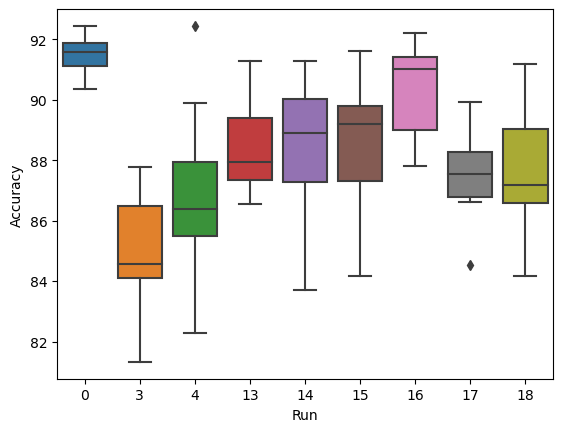

In [961]:
values = []
for i in range(len(metrics)):
    values.append(get_values(i, "verma", "system_accuracy", "val"))

dic = []
for value in values:
    dic.append(value.max())

df = pd.DataFrame(dic)
#df.index = ["False", "True"]
#df.index = df_runs[["mod"]]
df = df.T.reset_index(drop=True)
#df.columns = df_runs["mod"].astype("string") + "_" + df_runs["expert_predict"].astype("string") + "_" + df_runs["sample_equal"].astype("string")

df = df.T.iloc[[0, 3, 4, 13, 14, 15, 16, 17, 18]].T

sns.boxplot(df).set(
    xlabel='Run', 
    ylabel='Accuracy'
)

check_all_ttest(df[[0, 3, 4, 13, 14, 15, 16, 17, 18]], 0.1, False)

df_runs.iloc[[0, 3, 4, 13, 14, 15, 16, 17, 18]]



/tmp/ipykernel_2097622/380030797.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = ttest_ind(value1, value2, equal_var=equal_var)
/home/joli/joli-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/joli/joli-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


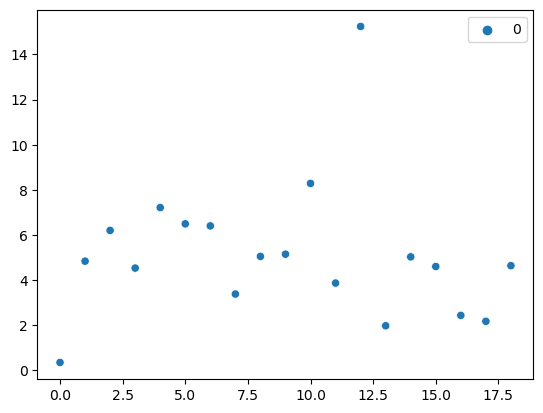

In [962]:
values = []
for i in range(len(metrics)):
    values.append(get_values(i, "verma", "system_accuracy", "val"))

dic = []
for value in values:
    dic.append(value.max().var())

df = pd.DataFrame(dic)
#df.index = ["False", "True"]
#df.index = df_runs[["mod"]]
df = df.T.reset_index(drop=True)
#df.columns = df_runs["mod"].astype("string") + "_" + df_runs["expert_predict"].astype("string") + "_" + df_runs["sample_equal"].astype("string")

df = df.T.iloc[:].T

sns.scatterplot(df.T)

check_all_ttest(df, 0.1, False)

#df_runs.iloc[:]

Ttest_indResult(statistic=array([-9.17025071]), pvalue=array([5.69783022e-09]))
i: 0, j: 1
Ttest_indResult(statistic=array([-6.54382422]), pvalue=array([1.39531471e-06]))
i: 0, j: 2
Ttest_indResult(statistic=array([-5.97932146]), pvalue=array([5.11409533e-06]))
i: 0, j: 3
Ttest_indResult(statistic=array([-7.86471708]), pvalue=array([7.82604032e-08]))
i: 0, j: 4
Ttest_indResult(statistic=array([-8.79472882]), pvalue=array([1.18323415e-08]))
i: 0, j: 5
Ttest_indResult(statistic=array([-8.58819498]), pvalue=array([1.78235911e-08]))
i: 0, j: 6
Ttest_indResult(statistic=array([-7.2288986]), pvalue=array([3.0429608e-07]))
i: 0, j: 7
Ttest_indResult(statistic=array([-8.62704919]), pvalue=array([1.64944669e-08]))
i: 0, j: 8


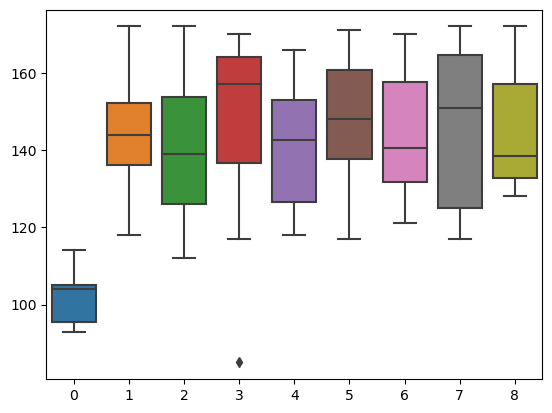

In [967]:
create_runs_plot(np.array(metrics)[[0, 3, 4, 13, 14, 15, 16, 17, 18]], "verma", "cov_classifier", "val")

Ttest_indResult(statistic=array([17.33241024]), pvalue=array([2.59385557e-14]))
i: 0, j: 1
Ttest_indResult(statistic=array([18.40485075]), pvalue=array([7.51316164e-15]))
i: 0, j: 2
Ttest_indResult(statistic=array([12.33493917]), pvalue=array([2.33889451e-11]))
i: 0, j: 3
Ttest_indResult(statistic=array([9.00815719]), pvalue=array([7.79351401e-09]))
i: 0, j: 4
Ttest_indResult(statistic=array([20.35553612]), pvalue=array([9.21640073e-16]))
i: 0, j: 5
Ttest_indResult(statistic=array([18.69686331]), pvalue=array([5.42105745e-15]))
i: 0, j: 6
Ttest_indResult(statistic=array([17.51083919]), pvalue=array([2.10101706e-14]))
i: 0, j: 7
Ttest_indResult(statistic=array([16.46665478]), pvalue=array([7.41185887e-14]))
i: 0, j: 8
Ttest_indResult(statistic=array([10.27444892]), pvalue=array([7.35920102e-10]))
i: 0, j: 9
Ttest_indResult(statistic=array([16.32859291]), pvalue=array([8.80116875e-14]))
i: 0, j: 10
Ttest_indResult(statistic=array([15.76241413]), pvalue=array([1.80408575e-13]))
i: 0, j: 1

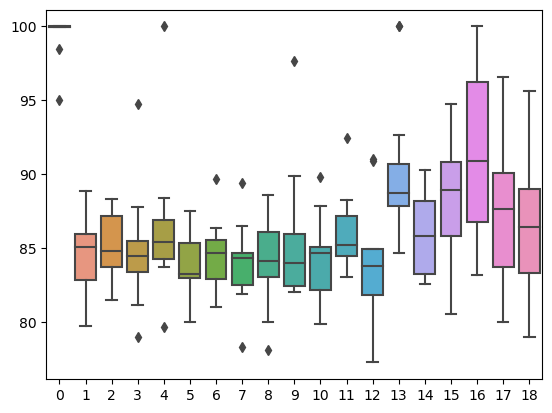

In [968]:
create_runs_plot(metrics, "verma", "classifier_accuracy", "val")

Ttest_indResult(statistic=array([6.63105483]), pvalue=array([3.31849739e-05]))
i: 0, j: 1
Ttest_indResult(statistic=array([13.94889265]), pvalue=array([3.66516185e-09]))
i: 0, j: 2
Ttest_indResult(statistic=array([9.46535655]), pvalue=array([7.21158544e-07]))
i: 0, j: 3
Ttest_indResult(statistic=array([6.3825314]), pvalue=array([3.85579804e-05]))
i: 0, j: 4
Ttest_indResult(statistic=array([10.01300342]), pvalue=array([3.62252988e-07]))
i: 0, j: 5
Ttest_indResult(statistic=array([13.03240911]), pvalue=array([1.11815667e-08]))
i: 0, j: 6
Ttest_indResult(statistic=array([16.10438691]), pvalue=array([2.59026932e-10]))
i: 0, j: 7
Ttest_indResult(statistic=array([12.46160897]), pvalue=array([2.06529406e-08]))
i: 0, j: 8
Ttest_indResult(statistic=array([9.1618839]), pvalue=array([1.00939627e-06]))
i: 0, j: 9
Ttest_indResult(statistic=array([17.42089827]), pvalue=array([5.53795342e-11]))
i: 0, j: 10
Ttest_indResult(statistic=array([11.1370267]), pvalue=array([5.53282558e-08]))
i: 0, j: 11
Ttes

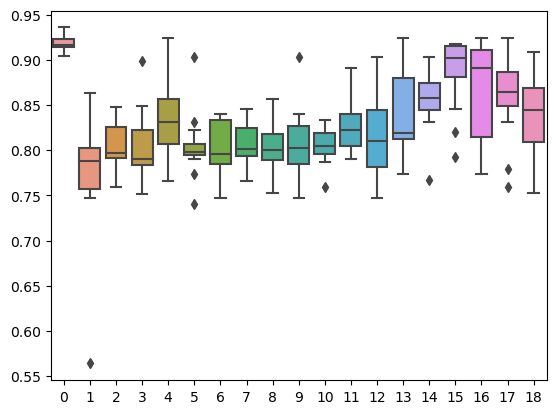

In [974]:
values = []
for i in range(len(metrics)):
    values.append(get_values(i, "hemmer", "system_accuracy", "val"))

dic = []
for value in values:
    dic.append(value.max())

df = pd.DataFrame(dic)
#df.index = ["False", "True"]
df = df.T.reset_index(drop=True)

#df = df.T.iloc[[0, 3, 4, 13, 14, 15, 16, 17, 18]].T

sns.boxplot(df)

check_all_ttest(df, 0.05, False)

Ttest_indResult(statistic=array([2.36274765]), pvalue=array([0.02739903]))
i: 0, j: 13
Ttest_indResult(statistic=array([2.43164745]), pvalue=array([0.02362784]))
i: 0, j: 14
Ttest_indResult(statistic=array([2.30187823]), pvalue=array([0.03118458]))
i: 4, j: 13
Ttest_indResult(statistic=array([2.39284046]), pvalue=array([0.02568828]))
i: 4, j: 14
Ttest_indResult(statistic=array([2.2475877]), pvalue=array([0.03495961]))
i: 5, j: 13
Ttest_indResult(statistic=array([2.36019311]), pvalue=array([0.02754899]))
i: 5, j: 14
Ttest_indResult(statistic=array([2.33092664]), pvalue=array([0.0293218]))
i: 6, j: 13
Ttest_indResult(statistic=array([2.4116778]), pvalue=array([0.0246682]))
i: 6, j: 14
Ttest_indResult(statistic=array([2.28286634]), pvalue=array([0.03246187]))
i: 8, j: 13
Ttest_indResult(statistic=array([2.38502914]), pvalue=array([0.0261226]))
i: 8, j: 14
Ttest_indResult(statistic=array([2.21207087]), pvalue=array([0.03765018]))
i: 9, j: 14


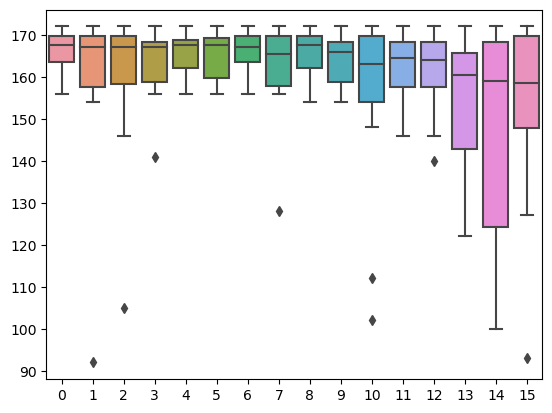

In [833]:
create_runs_plot(metrics, "hemmer", "Classifier Coverage", "val")

Ttest_indResult(statistic=array([2.83136409]), pvalue=array([0.00971699]))
i: 1, j: 12
Ttest_indResult(statistic=array([4.21571571]), pvalue=array([0.00035626]))
i: 1, j: 13
Ttest_indResult(statistic=array([2.41484868]), pvalue=array([0.02450022]))
i: 2, j: 12
Ttest_indResult(statistic=array([4.07570774]), pvalue=array([0.00050146]))
i: 2, j: 13
Ttest_indResult(statistic=array([3.18816069]), pvalue=array([0.0042489]))
i: 3, j: 12
Ttest_indResult(statistic=array([4.32158496]), pvalue=array([0.00027505]))
i: 3, j: 13
Ttest_indResult(statistic=array([2.1367317]), pvalue=array([0.04398993]))
i: 3, j: 14
Ttest_indResult(statistic=array([2.27175879]), pvalue=array([0.0332301]))
i: 4, j: 12
Ttest_indResult(statistic=array([4.01357151]), pvalue=array([0.00058352]))
i: 4, j: 13
Ttest_indResult(statistic=array([2.25537577]), pvalue=array([0.03439358]))
i: 5, j: 12
Ttest_indResult(statistic=array([3.98844001]), pvalue=array([0.00062038]))
i: 5, j: 13
Ttest_indResult(statistic=array([3.05573414]),

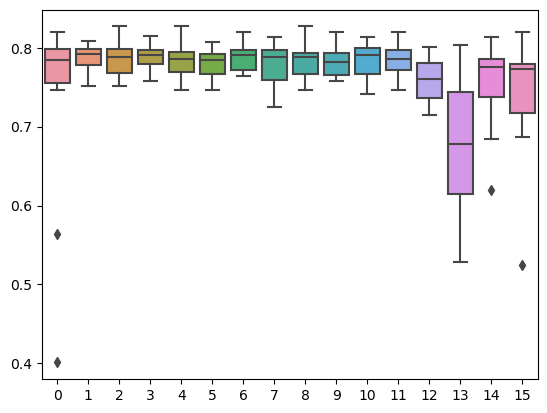

In [834]:
create_runs_plot(metrics, "hemmer", "Classifier Accuracy", "val")

In [725]:
metrics[0]["hemmer"]

{1: {0: {'train': {1: {'system_accuracy': 0.5083333333333333,
     'train_system_loss': 0.7703079004238145,
     'Classifier Accuracy': 0.5083333333333333,
     'Classifier Task Subset Accuracy': 0.5083333333333333,
     'Classifier Coverage': 1.0,
     'Expert_4323195249': {'expert_accuracy': 0.9133333333333333,
      'expert_task_subset_accuracy': 0,
      'expert_coverage': 0.0},
     'Expert_4295232296': {'expert_accuracy': 0.7933333333333333,
      'expert_task_subset_accuracy': 0,
      'expert_coverage': 0.0}},
    2: {'system_accuracy': 0.7766666666666666,
     'train_system_loss': 0.49076990397351816,
     'Classifier Accuracy': 0.7766666666666666,
     'Classifier Task Subset Accuracy': 0.7766666666666666,
     'Classifier Coverage': 1.0,
     'Expert_4323195249': {'expert_accuracy': 0.9133333333333333,
      'expert_task_subset_accuracy': 0,
      'expert_coverage': 0.0},
     'Expert_4295232296': {'expert_accuracy': 0.7933333333333333,
      'expert_task_subset_accuracy': 0

84

In [644]:
values = []
for i in range(len(metrics)):
    values.append(get_values(i, "verma", "cov_experts", "val"))
values

[   Seed_1_Fold_0 Seed_1_Fold_1 Seed_1_Fold_2 Seed_1_Fold_3 Seed_2_Fold_0  \
 0       [47, 33]       [98, 4]      [41, 18]       [6, 49]      [16, 10]   
 1        [29, 0]       [52, 0]       [23, 1]       [0, 14]        [4, 6]   
 2        [23, 1]       [20, 0]       [28, 1]       [0, 11]       [6, 11]   
 3        [22, 6]       [19, 1]       [36, 2]       [0, 12]      [10, 14]   
 4        [21, 8]       [30, 1]       [27, 9]       [1, 24]      [12, 14]   
 5        [18, 7]       [29, 6]       [44, 7]       [2, 19]      [25, 13]   
 6       [23, 16]      [43, 11]      [33, 12]       [7, 22]      [22, 20]   
 7       [15, 11]      [33, 10]      [32, 18]       [7, 30]      [21, 19]   
 8        [22, 9]       [36, 2]      [27, 18]       [8, 21]      [17, 16]   
 9       [15, 10]       [40, 9]      [34, 23]       [7, 24]      [19, 18]   
 10      [29, 15]      [34, 12]      [37, 15]      [10, 24]      [26, 17]   
 11      [24, 15]       [40, 9]      [34, 14]       [8, 28]      [35, 16]   

In [674]:
import math

expert_metrics = []
for run in values:
    temp1 = {
        4323195249: {},
        4295232296: {},
    }
    for column in run:
        temp1[4323195249][column] = [el[0] if isinstance(el, list) else None for el in run[column]]
        temp1[4295232296][column] = [el[0] if isinstance(el, list) else None for el in run[column]]
    expert_metrics.append(temp1)

In [700]:
pd.DataFrame(pd.DataFrame(expert_metrics)[4323195249])

,4323195249
0,"{'Seed_1_Fold_0': [47, 29, 23, 22, 21, 18, 23,..."
1,"{'Seed_1_Fold_0': [44, 13, 4, 15, 19, 34, 36, ..."
2,"{'Seed_1_Fold_0': [77, 64, 62, 46, 32, 44, 43,..."
3,"{'Seed_1_Fold_0': [78, 73, 75, 50, 33, 37, 41,..."
4,"{'Seed_1_Fold_0': [72, 17, 9, 8, 16, 26, 22, 1..."
5,"{'Seed_1_Fold_0': [83, 41, 16, 12, 17, 17, 24,..."
6,"{'Seed_1_Fold_0': [74, 20, 8, 7, 21, 16, 18, 2..."
7,"{'Seed_1_Fold_0': [124, 107, 88, 52, 44, 35, 4..."


In [673]:
df1 = pd.DataFrame(temp1[4323195249])

In [671]:
df11 = df1.fillna(df1.mean())
pd.DataFrame(df11.mean())

,0
Seed_1_Fold_0,24.115385
Seed_1_Fold_1,39.846154
Seed_1_Fold_2,37.923077
Seed_1_Fold_3,6.038462
Seed_2_Fold_0,21.500000
Seed_2_Fold_1,10.230769
Seed_2_Fold_2,23.576923
Seed_2_Fold_3,45.269231
Seed_3_Fold_0,32.269231
Seed_3_Fold_1,32.222222


In [648]:
pd.DataFrame(temp1[4323195249])

,Seed_1_Fold_0,Seed_1_Fold_1,Seed_1_Fold_2,Seed_1_Fold_3,Seed_2_Fold_0,Seed_2_Fold_1,Seed_2_Fold_2,Seed_2_Fold_3,Seed_3_Fold_0,Seed_3_Fold_1,Seed_3_Fold_2,Seed_3_Fold_3
0,47.0,98.0,41.0,6.0,16.0,21.0,14.0,57.0,24.0,60,94.0,75
1,29.0,52.0,23.0,0.0,4.0,0.0,8.0,79.0,23.0,33,92.0,113
2,23.0,20.0,28.0,0.0,6.0,1.0,5.0,66.0,33.0,15,59.0,76
3,22.0,19.0,36.0,0.0,10.0,1.0,13.0,37.0,39.0,17,51.0,53
4,21.0,30.0,27.0,1.0,12.0,9.0,19.0,40.0,28.0,12,42.0,30
5,18.0,29.0,44.0,2.0,25.0,12.0,22.0,39.0,30.0,17,40.0,25
6,23.0,43.0,33.0,7.0,22.0,5.0,20.0,35.0,17.0,31,29.0,47
7,15.0,33.0,32.0,7.0,21.0,11.0,26.0,39.0,26.0,28,60.0,35
8,22.0,36.0,27.0,8.0,17.0,9.0,35.0,31.0,29.0,32,45.0,56
9,15.0,40.0,34.0,7.0,19.0,10.0,29.0,41.0,37.0,32,40.0,56


In [607]:
values[0]

,Seed_1_Fold_0,Seed_1_Fold_1,Seed_1_Fold_2,Seed_1_Fold_3,Seed_2_Fold_0,Seed_2_Fold_1,Seed_2_Fold_2,Seed_2_Fold_3,Seed_3_Fold_0,Seed_3_Fold_1,Seed_3_Fold_2,Seed_3_Fold_3
0,"[47, 33]","[98, 4]","[41, 18]","[6, 49]","[16, 10]","[21, 23]","[14, 3]","[57, 1]","[24, 3]","[60, 65]","[94, 1]","[75, 16]"
1,"[29, 0]","[52, 0]","[23, 1]","[0, 14]","[4, 6]","[0, 0]","[8, 0]","[79, 0]","[23, 0]","[33, 65]","[92, 0]","[113, 3]"
2,"[23, 1]","[20, 0]","[28, 1]","[0, 11]","[6, 11]","[1, 0]","[5, 0]","[66, 0]","[33, 0]","[15, 76]","[59, 0]","[76, 7]"
3,"[22, 6]","[19, 1]","[36, 2]","[0, 12]","[10, 14]","[1, 0]","[13, 0]","[37, 0]","[39, 0]","[17, 65]","[51, 0]","[53, 17]"
4,"[21, 8]","[30, 1]","[27, 9]","[1, 24]","[12, 14]","[9, 0]","[19, 0]","[40, 0]","[28, 1]","[12, 57]","[42, 0]","[30, 17]"
5,"[18, 7]","[29, 6]","[44, 7]","[2, 19]","[25, 13]","[12, 3]","[22, 0]","[39, 0]","[30, 8]","[17, 37]","[40, 2]","[25, 12]"
6,"[23, 16]","[43, 11]","[33, 12]","[7, 22]","[22, 20]","[5, 4]","[20, 2]","[35, 0]","[17, 8]","[31, 45]","[29, 2]","[47, 26]"
7,"[15, 11]","[33, 10]","[32, 18]","[7, 30]","[21, 19]","[11, 1]","[26, 2]","[39, 0]","[26, 3]","[28, 44]","[60, 4]","[35, 27]"
8,"[22, 9]","[36, 2]","[27, 18]","[8, 21]","[17, 16]","[9, 1]","[35, 0]","[31, 0]","[29, 8]","[32, 39]","[45, 6]","[56, 16]"
9,"[15, 10]","[40, 9]","[34, 23]","[7, 24]","[19, 18]","[10, 3]","[29, 0]","[41, 0]","[37, 9]","[32, 48]","[40, 7]","[56, 16]"


In [ ]:
dict_run = {}
for run in range(len(metrics)):
    dict_seed = {}
    for seed, val1 in metrics[run]["verma"].items():
        dict_fold = {}
        for fold, element in metrics[run]["verma"][seed].items():
            dict_fold[f"Fold_{fold}"] = create_dataframe_one_metric(metrics, run, "verma", seed, fold, "val")
        df_seed = pd.concat(dict_fold)
        dict_seed[f"Seed_{seed}"] = df_seed
    df_run = pd.concat(dict_seed)
    dict_run[f"Run_{run}"] = df_run
pd.concat(dict_run)

## Experts

In [928]:
import matplotlib.pyplot as plt

def get_expert_values(step, metric_name):

    mett = []
    for element in metrics:
        met = {}
        for seed, value1 in element["expert metrics"].items():
            for fold, value2 in value1.items():
                for expert, value3 in value2.items():
                    if expert not in met:
                        met[expert] = {}
                    met[expert][f"Seed_{seed}_Fold_{fold}"] = {}
                    met[expert][f"Seed_{seed}_Fold_{fold}"]["End"] = value3[step]["End"][metric_name]
                    if "Start" in value3[step]:
                        met[expert][f"Seed_{seed}_Fold_{fold}"]["Start"] = value3[step]["Start"][metric_name]
                    else:
                        pass
        mett.append(met)
    return mett

def get_single_values(met, run, expert_id, step):
    values = []
    for key, value in met[run][expert_id].items():
        values.append(value[step])
    return values

def plot_expert_values(met):
    df1 = pd.DataFrame(met[4323195249])
    df2 = pd.DataFrame(met[4295232296])

    fd1 = df1.T.reset_index()
    fd1["expert"] = 4323195249
    fd2 = df2.T.reset_index()
    fd2["expert"] = 4295232296
    df3 = pd.concat([fd1, fd2])
    df3 = df3.melt(id_vars=["index", "expert"])

    plt.figure()
    sns.boxplot(df3, x="expert", y="value",
            hue="variable",)

In [939]:
metrics[18]["expert metrics"]

{1: {0: {}, 1: {}, 2: {}, 3: {}},
 2: {0: {}, 1: {}, 2: {}, 3: {}},
 3: {0: {}, 1: {}, 2: {}, 3: {}}}

,labeler_ids,init_size,labels_per_round,rounds,labeled,cost,overlap,setting,mod,expert_predict,sample_equal
0,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,False
1,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,True
2,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,False
3,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,True
4,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,False
5,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,True
6,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,False
7,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,True
8,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,False
9,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,True


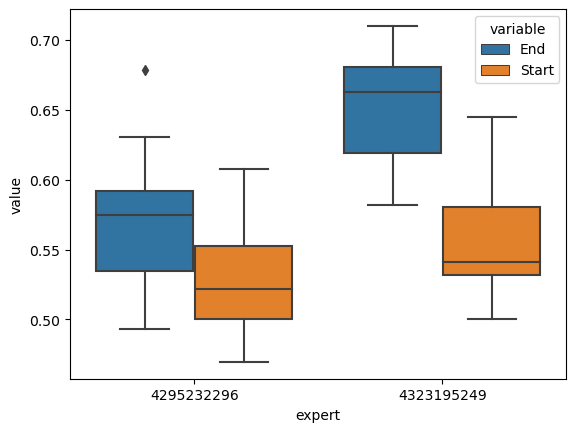

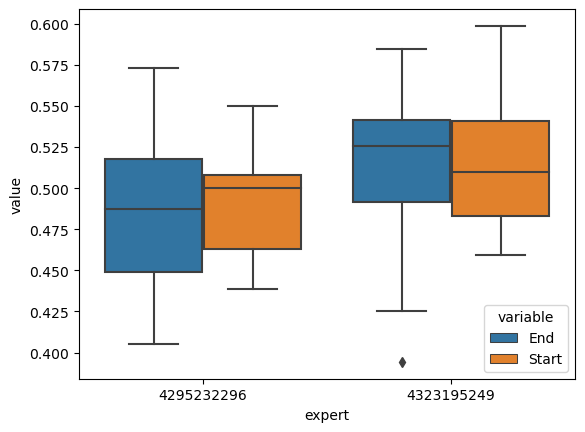

In [931]:
met = get_expert_values("Val", "accurancy_balanced")

plot_expert_values(met[2])
plot_expert_values(met[1])
df_runs

In [924]:
met = get_expert_values("Val", "accurancy_balanced")

for i in range(16):

    run = i
    expert = 4323195249

    if df_runs.iloc[i]["mod"] == "ssl":
        continue

    v1 = get_single_values(met, run, expert, "Start")
    v2 = get_single_values(met, run, expert, "End")

    res = get_ttest(v1, v2)
    if res.pvalue <= 0.05:
        print(f"run {run} with p {res.pvalue} for expert {expert}")

    expert = 4295232296

    v1 = get_single_values(met, run, expert, "Start")
    v2 = get_single_values(met, run, expert, "End")

    get_ttest(v1, v2)

    res = get_ttest(v1, v2)
    if res.pvalue <= 0.05:
        print(f"run {run} with p {res.pvalue} for expert {expert}")

run 2 with p 6.19540626091039e-05 for expert 4323195249
run 2 with p 0.0469923322181665 for expert 4295232296
run 3 with p 2.3361743556462247e-05 for expert 4323195249
run 6 with p 2.7435772736443634e-07 for expert 4323195249
run 6 with p 0.002706800088076692 for expert 4295232296
run 7 with p 9.589903316162385e-05 for expert 4323195249
run 7 with p 0.04598397568702153 for expert 4295232296
run 8 with p 0.04008895794698606 for expert 4295232296
run 9 with p 0.046552365375806426 for expert 4295232296
run 10 with p 1.195760722104384e-08 for expert 4323195249
run 10 with p 0.0003275446433969614 for expert 4295232296
run 11 with p 2.994233304825926e-05 for expert 4323195249
run 11 with p 0.017748579219644563 for expert 4295232296
run 14 with p 0.0013615223130475273 for expert 4295232296
run 15 with p 0.03854894882308851 for expert 4323195249


In [925]:
df_runs

,labeler_ids,init_size,labels_per_round,rounds,labeled,cost,overlap,setting,mod,expert_predict,sample_equal
0,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,False
1,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,True
2,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,False
3,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,True
4,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,False
5,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,True
6,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,False
7,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,True
8,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,False
9,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,True


In [926]:
def create_expert_metrics(met):
    metrics = {}
    for expert_id in met[0]:
        metrics[expert_id] = []
        for run in met:
            start_metrics = {}
            end_metrics = {}
            for seed_fold, value in run[expert_id].items():
                if "Start" in value:
                    start_metrics[seed_fold] = value["Start"]
                end_metrics[seed_fold] = value["End"]
            if len(start_metrics) == 0:
                start_metrics = end_metrics
            metrics[expert_id].append({
                "Start": start_metrics,
                "End": end_metrics
            })
    return metrics

def get_expert_df(metrics, expert_id, start=False):
    if start:
        df1 = pd.DataFrame([row["Start"] for row in metrics[expert_id]]).reset_index().melt(id_vars=['index'], var_name='seed_fold', value_name='start')
    df2 = pd.DataFrame([row["End"] for row in metrics[expert_id]]).reset_index().melt(id_vars=['index'], var_name='seed_fold', value_name='end')

    if start:
        df_final = df1
        df_final["end"] = df2["end"]
    else:
        df_final = df2
    df_final = df_final.melt(id_vars=["index", "seed_fold"], var_name="step")

    return df_final

def plot_expert_runs_al(metrics, expert_id, step, metrics_name):
    met = get_expert_values(step, metrics_name)
    df = get_expert_df(create_expert_metrics(met), expert_id, start=True)
    plt.figure()
    sns.boxplot(df, x="index", y="value", hue="step")

def plot_expert_runs_end(metrics, expert_id, step, metrics_name):
    met = get_expert_values(step, metrics_name)
    df = get_expert_df(create_expert_metrics(met), expert_id)
    plt.figure()
    sns.boxplot(df, x="index", y="value")

In [927]:
plot_expert_runs_al(metrics, 4323195249, "Val", "accurancy_balanced")

KeyError: 4323195249

In [921]:
plot_expert_runs_al(metrics, 4295232296, "Val", "accurancy_balanced")

KeyError: 4323195249

In [922]:
plot_expert_runs_end(metrics, 4323195249, "Val", "accurancy_balanced")

KeyError: 4323195249

In [923]:
plot_expert_runs_end(metrics, 4295232296, "Val", "accurancy_balanced")

KeyError: 4323195249

In [503]:
temp = pd.DataFrame(metrics[4323195249]).reset_index().melt('index', var_name='step',  value_name='vals')
temp["vals"]

0     {'Seed_1_Fold_0': 0.5714285714285714, 'Seed_1_...
1     {'Seed_1_Fold_0': 0.48376623376623373, 'Seed_1...
2     {'Seed_1_Fold_0': 0.5383141762452107, 'Seed_1_...
3     {'Seed_1_Fold_0': 0.5523627075351213, 'Seed_1_...
4     {'Seed_1_Fold_0': 0.5422077922077922, 'Seed_1_...
5     {'Seed_1_Fold_0': 0.5064935064935064, 'Seed_1_...
6     {'Seed_1_Fold_0': 0.5346956151553852, 'Seed_1_...
7     {'Seed_1_Fold_0': 0.5162337662337663, 'Seed_1_...
8     {'Seed_1_Fold_0': 0.4253246753246753, 'Seed_1_...
9     {'Seed_1_Fold_0': 0.6215410813111962, 'Seed_1_...
10    {'Seed_1_Fold_0': 0.6700723712217964, 'Seed_1_...
11    {'Seed_1_Fold_0': 0.6331168831168831, 'Seed_1_...
12    {'Seed_1_Fold_0': 0.6233766233766234, 'Seed_1_...
13    {'Seed_1_Fold_0': 0.6875266070668369, 'Seed_1_...
Name: vals, dtype: object

In [ ]:
.melt(var_name='Expert', value_name='values')